# 金融信贷风控模型
## 贷后催收模型
> 案例数据为美国某p2p公司贷后数据

### 1.导入所需模块

In [451]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from time import strptime,mktime
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn import metrics


### 2.设置数据转换方法
* 第一个方法将划款率转换成logit形式
* 第二个方法为将分类数据变量的缺失转换成unkown
* 第三个方法为对连续型变量进行缺失数据填充，方法为预定义的repalcement

In [343]:
def LogitRR(x):
    '''
    :param x: 划款率，有的超过1，有的为0.做截断处理
    :return: 将还款率转化成logit变换
    '''
    if x >= 1:
        y = 0.9999
    elif x == 0:
        y = 0.0001
    else:
        y = x
    return np.log(y/(1-y))

def MakeupMissingCategorical(x):
    if str(x) == 'nan':
        return 'Unknown'
    else:
        return x

def MakeupMissingNumerical(x,replacement):
    if np.isnan(x):
        return replacement
    else:
        return x

### 3.数据读取与查看

In [372]:
foldOfData = r'C:\Users\pohch\Google Drive\Python notebook\Debt Collection modeling\debt_collection_model-master'
mydata = pd.read_csv(foldOfData+r'\prosperLoanData_chargedoff.csv',header = 0)
mydata_summary = mydata.dtypes
mydata_summary

ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
ProsperRating (numeric)                float64
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration                 int64
IsBorrowerHomeowner                       bool
CurrentlyInGroup                          bool
CreditScoreRangeLower                    int64
CreditScoreRangeUpper                    int64
FirstRecorded

In [361]:
#Examine the data types of features, print if indicate True
def CheckDatatype(df,printout='True'):
    feat_list = df.dtypes.to_frame(name="type") #get list of features in dataset
    feat_type_list = feat_list.groupby("type").count().index #get list of types of features in dataset
    if printout=='True':
        print('Feature Type List:',feat_type_list)
        print()
    list_feat_by_types =[]
    for feat in feat_type_list:
        if printout=='True':
            print(feat_list[feat_list.type==feat])
            print(feat_list[feat_list.type==feat].count())
            print('----------------------------------')
        list_feat_by_types.append([feat, mydata[feat_list[feat_list.type==feat].index].columns.values.tolist()])
    list_feat_by_types=pd.DataFrame(list_feat_by_types, columns =['Type','Feature_List']).set_index('Type')
    print ("Here is the list of features by their data type and returned as a Dataframe")
    print(list_feat_by_types)
    return list_feat_by_types
feat_table = CheckDatatype(mydata,'True')
#Examine the data types of features  

Feature Type List: Index([bool, int64, float64, object], dtype='object', name='type')

                     type
IsBorrowerHomeowner  bool
CurrentlyInGroup     bool
IncomeVerifiable     bool
type    3
dtype: int64
----------------------------------
                                type
ListingNumber                  int64
Term                           int64
ListingCategory (numeric)      int64
EmploymentStatusDuration       int64
CreditScoreRangeLower          int64
CreditScoreRangeUpper          int64
CurrentCreditLines             int64
OpenCreditLines                int64
TotalCreditLinespast7years     int64
OpenRevolvingAccounts          int64
OpenRevolvingMonthlyPayment    int64
InquiriesLast6Months           int64
TotalInquiries                 int64
CurrentDelinquencies           int64
AmountDelinquent               int64
DelinquenciesLast7Years        int64
PublicRecordsLast10Years       int64
PublicRecordsLast12Months      int64
RevolvingCreditBalance         int64
AvailableBa

In [296]:
'''#Split the dataframe columns wise according to data types
type_bool=mydata_table[mydata_table.type=="bool"].index
type_int64=mydata_table[mydata_table.type=="int64"].index
type_float64=mydata_table[mydata_table.type=="float64"].index
type_object = mydata_table[mydata_table.type=="object"].index
mydata_bool= mydata[mydata_table[mydata_table.type=="bool"].index]
mydata_int64= mydata[mydata_table[mydata_table.type=="int64"].index]
mydata_float64= mydata[mydata_table[mydata_table.type=="float64"].index]
mydata_object= mydata[mydata_table[mydata_table.type=="object"].index]
print("boolean type",type_bool)
print("int64 type",type_int64)
print("float64 type", type_float64)
print("object type", type_object)'''

'#Split the dataframe columns wise according to data types\ntype_bool=mydata_table[mydata_table.type=="bool"].index\ntype_int64=mydata_table[mydata_table.type=="int64"].index\ntype_float64=mydata_table[mydata_table.type=="float64"].index\ntype_object = mydata_table[mydata_table.type=="object"].index\nmydata_bool= mydata[mydata_table[mydata_table.type=="bool"].index]\nmydata_int64= mydata[mydata_table[mydata_table.type=="int64"].index]\nmydata_float64= mydata[mydata_table[mydata_table.type=="float64"].index]\nmydata_object= mydata[mydata_table[mydata_table.type=="object"].index]\nprint("boolean type",type_bool)\nprint("int64 type",type_int64)\nprint("float64 type", type_float64)\nprint("object type", type_object)'

### Prior Bias Analysis
> jdksjfal

In [116]:
null_table = mydata.isnull().sum().to_frame('null_records')
null_table[mydata.isnull().sum()>0]

,null_records
CreditGrade,1127
ProsperRating (numeric),1920
ProsperScore,1920
BorrowerState,204
DebtToIncomeRatio,209
TotalProsperLoans,2494
TotalProsperPaymentsBilled,2494
OnTimeProsperPayments,2494
ProsperPaymentsLessThanOneMonthLate,2494
ProsperPaymentsOneMonthPlusLate,2494


In [421]:
Int64_list = feat_table['Int64':'Int64'].Feature_List.values.tolist()[0]
Float64_list = feat_table['Float64':'Float64'].Feature_List.values.tolist()[0]
corr_Int64 = mydata[Int64_list].corr()
corr_Float64=mydata[Float64_list].corr()
#corr_Int64.index[corr_Int64[:]>0.5]
mydata[Int64_list]
#mydata[Float64_list]

,ListingNumber,Term,ListingCategory (numeric),EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,...,AvailableBankcardCredit,TotalTrades,TradesOpenedLast6Months,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,Recommendations,InvestmentFromFriendsCount,Investors
0,496566,36,7,213,680,699,4,5,53,3,...,2006,50,1,298,30,36,2500,0,0,50
1,292860,36,1,47,520,539,3,4,13,2,...,0,10,1,1966,11,72,2551,0,0,67
2,308345,36,7,20,700,719,7,6,13,4,...,3578,10,1,2057,7,71,2500,0,0,85
3,532077,36,1,59,720,739,9,7,27,5,...,1997,9,2,783,8,29,6000,0,0,2
4,361026,36,2,158,680,699,8,4,18,2,...,3500,15,2,1308,29,68,4000,0,0,92
5,758046,60,15,98,620,639,6,6,39,5,...,30,32,0,260,6,11,4000,0,0,58
6,162461,36,0,169,560,579,5,3,57,4,...,220,46,1,2007,18,80,3000,0,0,27
7,551688,36,1,3,640,659,18,13,62,3,...,1223,27,0,320,19,26,4000,0,0,2
8,340424,36,1,55,600,619,4,3,30,2,...,0,23,0,1951,10,69,1000,1,0,37
9,460749,36,7,26,600,619,6,5,11,2,...,0,6,1,545,31,45,1000,0,0,31


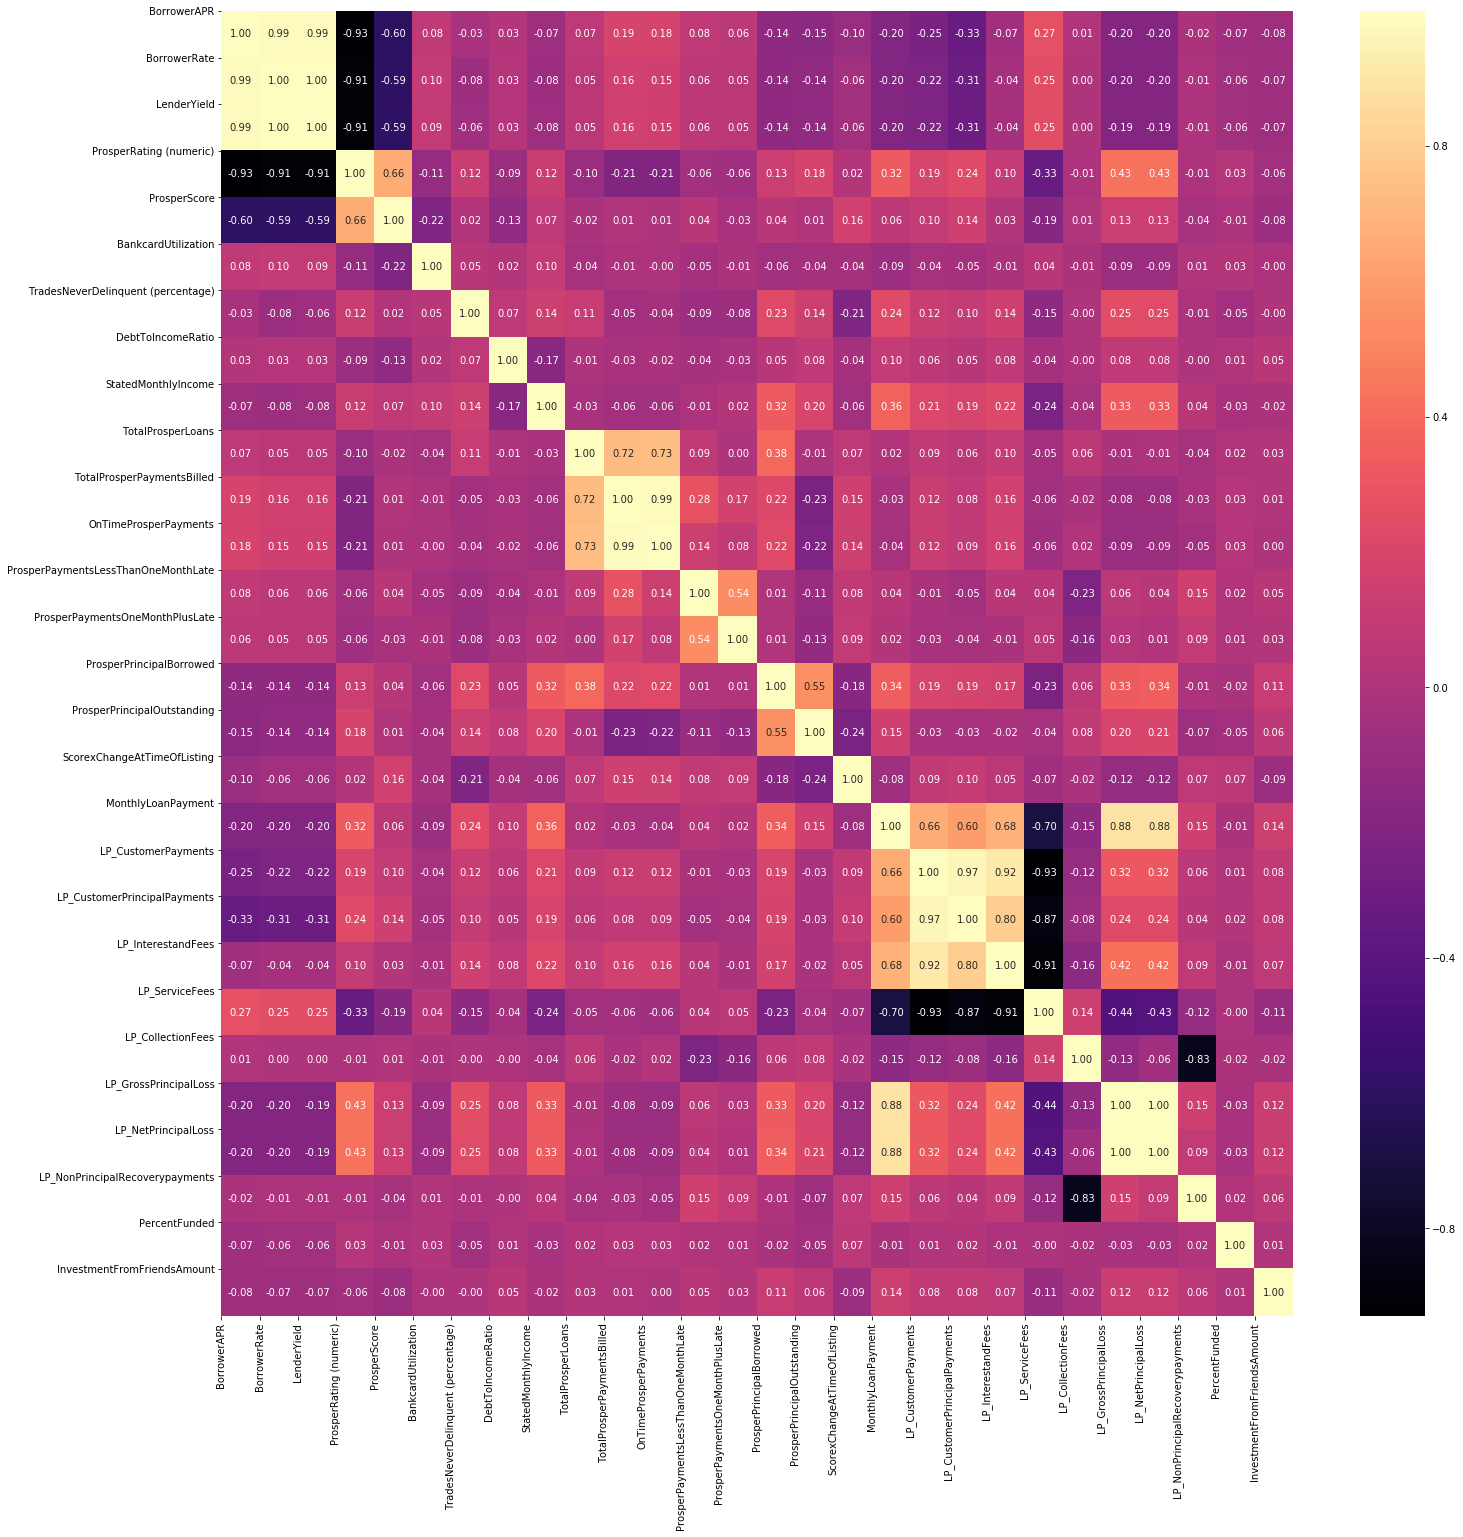

In [278]:
#Plot figsize
fig, ax = plt.subplots(figsize=(24,24))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_Float64, cmap='magma', annot=True, fmt=".2f", annot_kws={"size":10})
#Apply xticks
plt.xticks(range(len(corr_Float64.columns)), corr_Float64.columns)
#Apply yticks
plt.yticks(range(len(corr_Float64.columns)), corr_Float64.columns)
#show plot
plt.show()

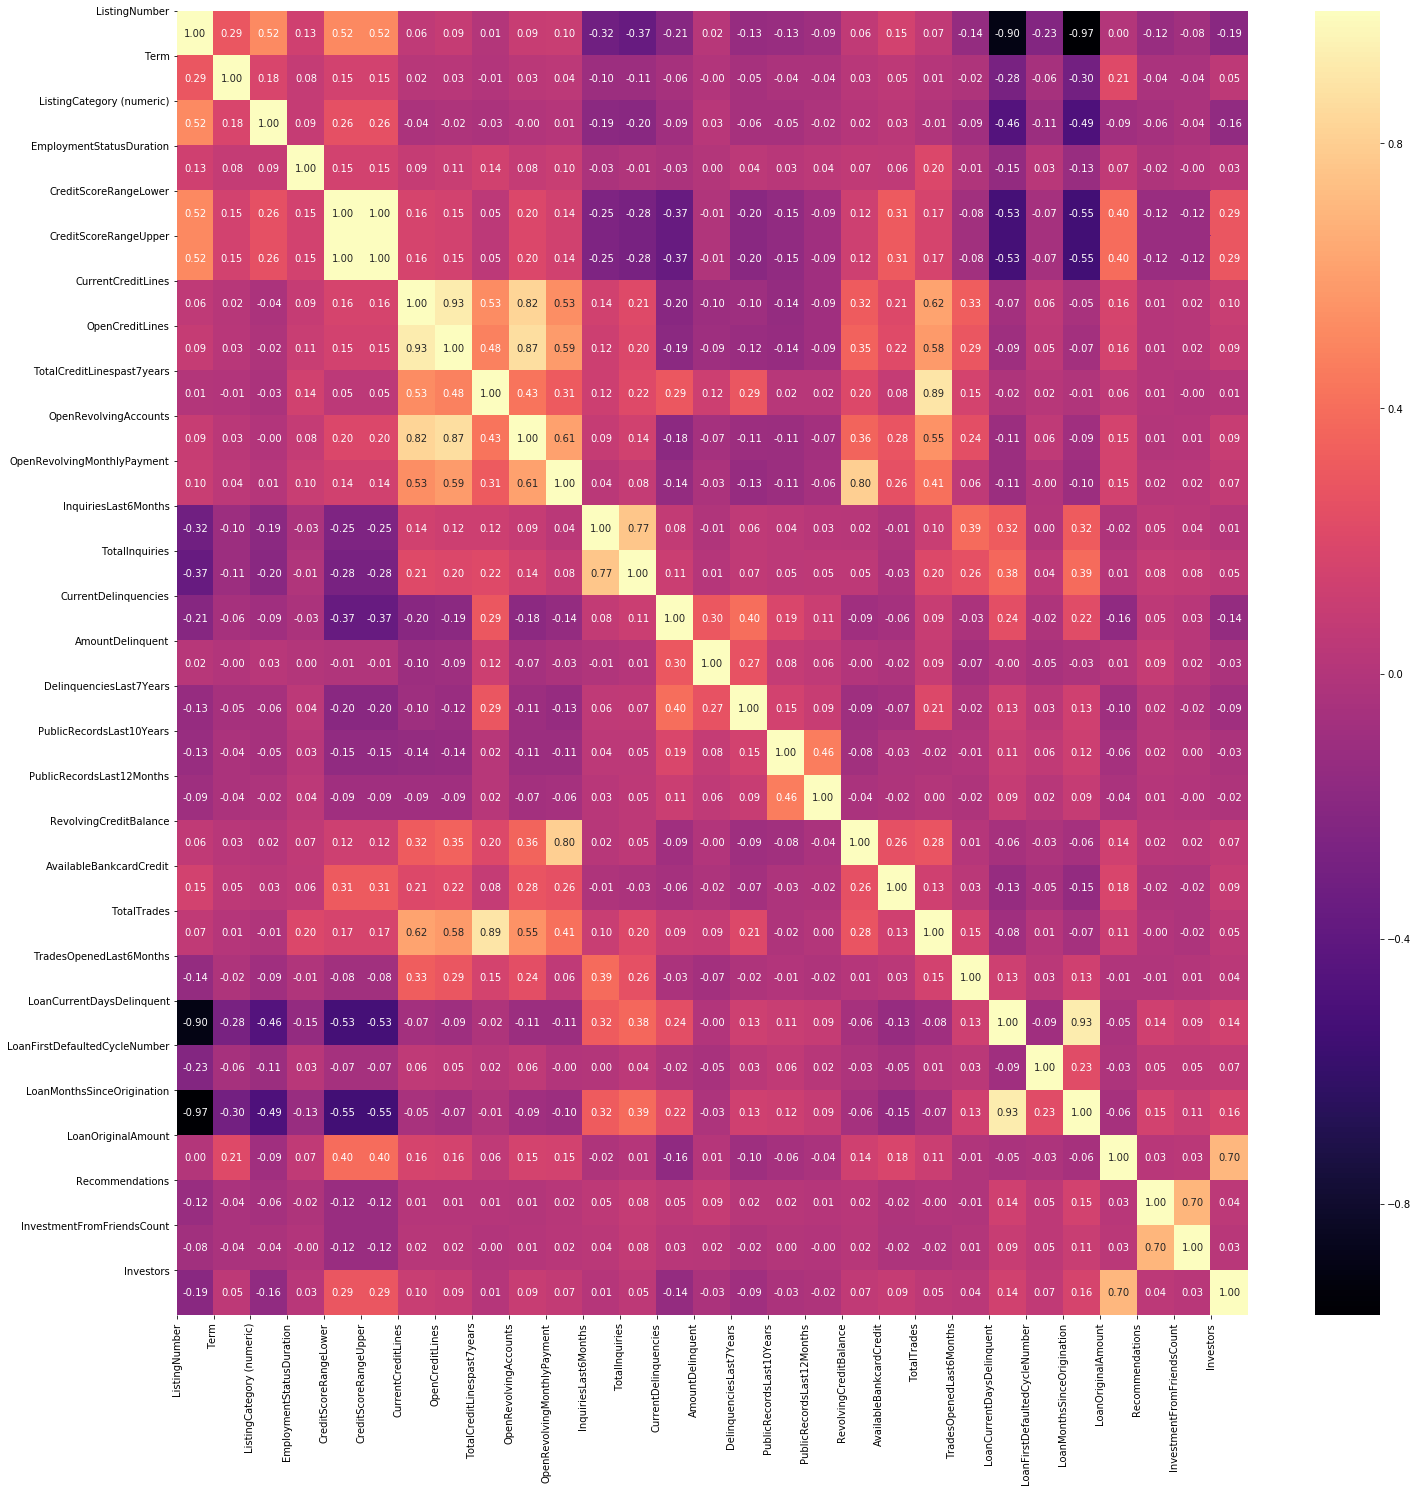

In [279]:
fig, ax = plt.subplots(figsize=(24,24))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_Int64, cmap='magma', annot=True, fmt=".2f", annot_kws={"size":10})
#Apply xticks
plt.xticks(range(len(corr_Int64.columns)), corr_Int64.columns)
#Apply yticks
plt.yticks(range(len(corr_Int64.columns)), corr_Int64.columns)
#show plot
plt.show()

In [363]:
list_feat_by_types

,Feature List
Type,
bool,"[IsBorrowerHomeowner, CurrentlyInGroup, Income..."
int64,"[ListingNumber, Term, ListingCategory (numeric..."
float64,"[BorrowerAPR, BorrowerRate, LenderYield, Prosp..."
object,"[ListingKey, ListingCreationDate, CreditGrade,..."


Continuous variables frequencies


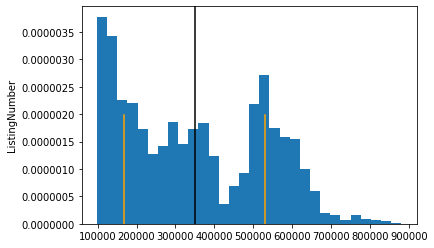

count      3046.000000
mean     349745.600131
std      181515.139025
min       98280.000000
25%      178009.000000
50%      330197.500000
75%      519280.250000
max      880346.000000
Name: ListingNumber, dtype: float64
-----------------------------------------------------------------


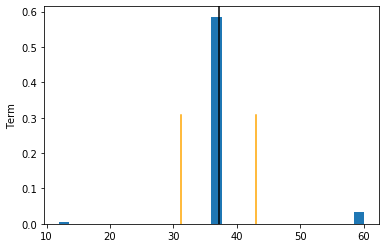

count    3046.000000
mean       37.134603
std         5.918739
min        12.000000
25%        36.000000
50%        36.000000
75%        36.000000
max        60.000000
Name: Term, dtype: float64
ordinal values [36 60 12]
-----------------------------------------------------------------


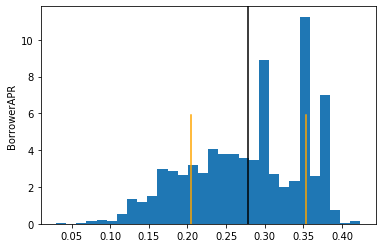

count    3046.000000
mean        0.278995
std         0.074141
min         0.029980
25%         0.223635
50%         0.291035
75%         0.351320
max         0.423950
Name: BorrowerAPR, dtype: float64
-----------------------------------------------------------------


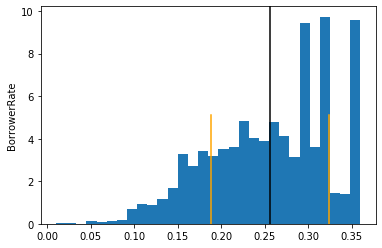

count    3046.000000
mean        0.256069
std         0.067817
min         0.010000
25%         0.204900
50%         0.262750
75%         0.315225
max         0.360000
Name: BorrowerRate, dtype: float64
-----------------------------------------------------------------


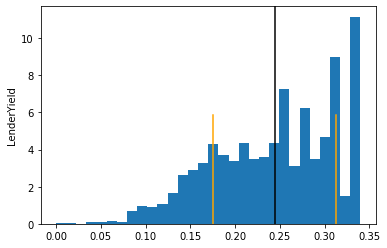

count    3046.000000
mean        0.244253
std         0.068459
min         0.000000
25%         0.190000
50%         0.250000
75%         0.305225
max         0.340000
Name: LenderYield, dtype: float64
-----------------------------------------------------------------


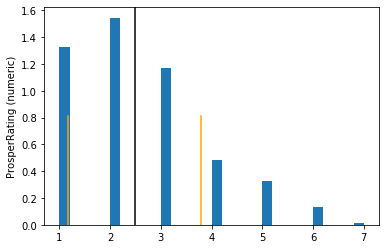

count    1126.000000
mean        2.480462
std         1.319620
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: ProsperRating (numeric), dtype: float64
-----------------------------------------------------------------


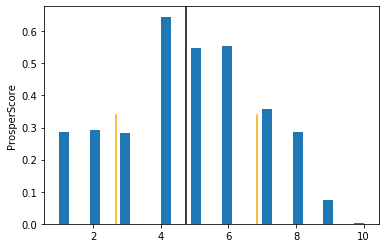

count    1126.000000
mean        4.760213
std         2.097460
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: ProsperScore, dtype: float64
-----------------------------------------------------------------


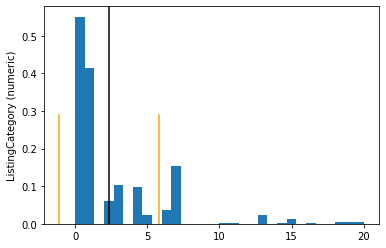

count    3046.000000
mean        2.347997
std         3.444284
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        20.000000
Name: ListingCategory (numeric), dtype: float64
-----------------------------------------------------------------


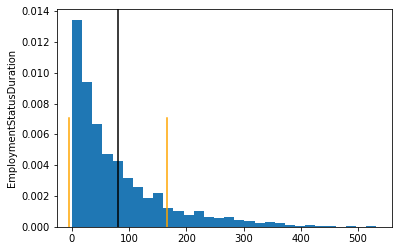

count    3046.000000
mean       79.839133
std        85.774270
min         0.000000
25%        19.000000
50%        50.000000
75%       111.000000
max       532.000000
Name: EmploymentStatusDuration, dtype: float64
-----------------------------------------------------------------


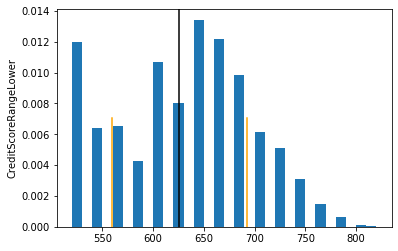

count    3046.000000
mean      625.804334
std        66.299265
min       520.000000
25%       580.000000
50%       640.000000
75%       680.000000
max       820.000000
Name: CreditScoreRangeLower, dtype: float64
-----------------------------------------------------------------


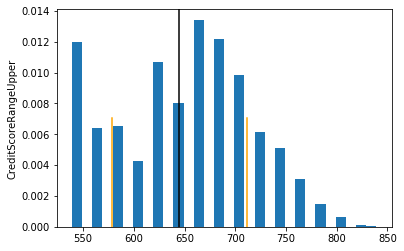

count    3046.000000
mean      644.804334
std        66.299265
min       539.000000
25%       599.000000
50%       659.000000
75%       699.000000
max       839.000000
Name: CreditScoreRangeUpper, dtype: float64
-----------------------------------------------------------------


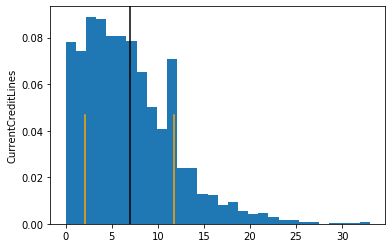

count    3046.000000
mean        6.940250
std         4.786034
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        33.000000
Name: CurrentCreditLines, dtype: float64
-----------------------------------------------------------------


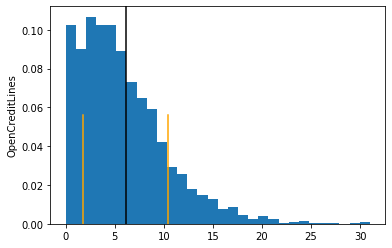

count    3046.000000
mean        6.135916
std         4.322763
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        31.000000
Name: OpenCreditLines, dtype: float64
-----------------------------------------------------------------


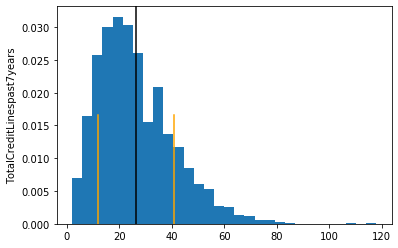

count    3046.000000
mean       26.387065
std        14.431227
min         2.000000
25%        16.000000
50%        24.000000
75%        35.000000
max       118.000000
Name: TotalCreditLinespast7years, dtype: float64
-----------------------------------------------------------------


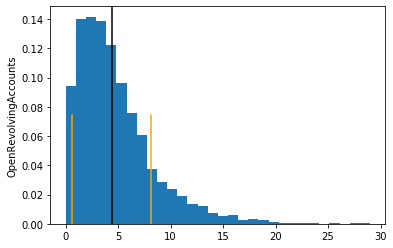

count    3046.000000
mean        4.370978
std         3.739146
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        29.000000
Name: OpenRevolvingAccounts, dtype: float64
-----------------------------------------------------------------


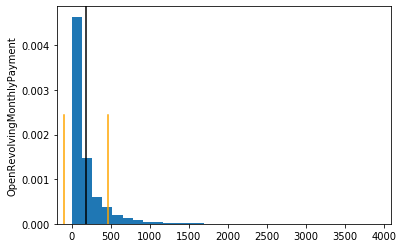

count    3046.000000
mean      178.132305
std       283.979064
min         0.000000
25%        24.000000
50%        87.000000
75%       217.000000
max      3902.000000
Name: OpenRevolvingMonthlyPayment, dtype: float64
-----------------------------------------------------------------


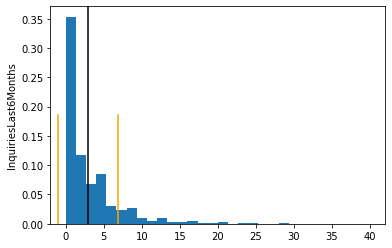

count    3046.000000
mean        2.954695
std         3.955655
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        40.000000
Name: InquiriesLast6Months, dtype: float64
-----------------------------------------------------------------


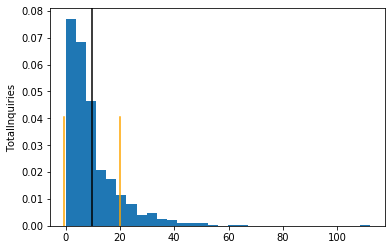

count    3046.000000
mean        9.797439
std        10.347937
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       112.000000
Name: TotalInquiries, dtype: float64
-----------------------------------------------------------------


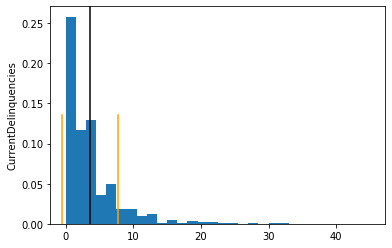

count    3046.000000
mean        3.612278
std         4.173539
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        45.000000
Name: CurrentDelinquencies, dtype: float64
-----------------------------------------------------------------


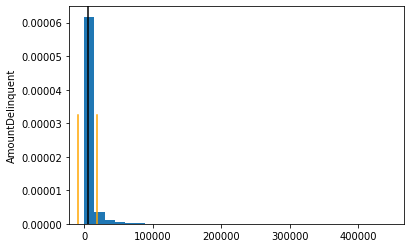

count      3046.000000
mean       5208.608011
std       14028.019169
min           1.000000
25%         319.250000
50%        1256.000000
75%        5026.000000
max      444745.000000
Name: AmountDelinquent, dtype: float64
-----------------------------------------------------------------


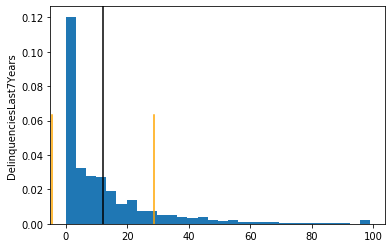

count    3046.000000
mean       12.248194
std        16.638397
min         0.000000
25%         0.000000
50%         6.000000
75%        17.000000
max        99.000000
Name: DelinquenciesLast7Years, dtype: float64
-----------------------------------------------------------------


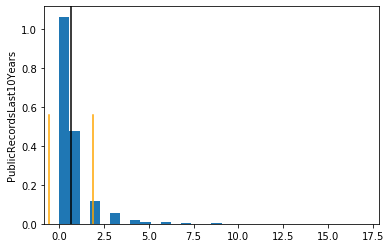

count    3046.000000
mean        0.660538
std         1.239338
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        17.000000
Name: PublicRecordsLast10Years, dtype: float64
-----------------------------------------------------------------


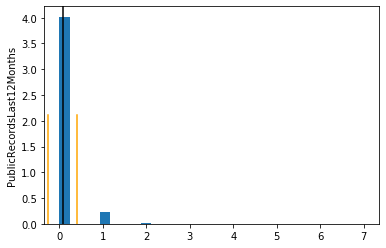

count    3046.000000
mean        0.073867
std         0.340182
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: PublicRecordsLast12Months, dtype: float64
ordinal values [0 1 2 7 4 3]
-----------------------------------------------------------------


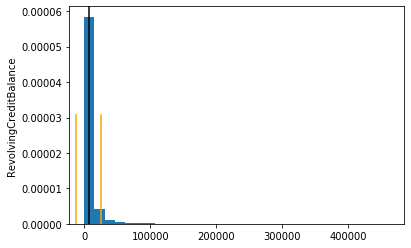

count      3046.000000
mean       6619.536441
std       19034.771647
min           0.000000
25%         281.500000
50%        1727.000000
75%        5877.750000
max      460885.000000
Name: RevolvingCreditBalance, dtype: float64
-----------------------------------------------------------------


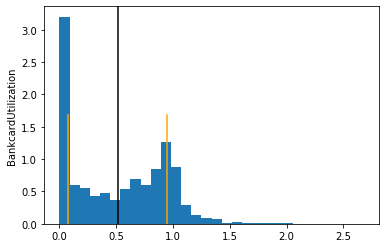

count    3046.000000
mean        0.512850
std         0.433415
min         0.000000
25%         0.030000
50%         0.530000
75%         0.900000
max         2.680000
Name: BankcardUtilization, dtype: float64
-----------------------------------------------------------------


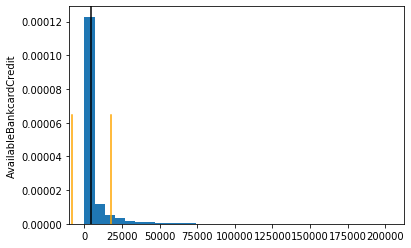

count      3046.000000
mean       4621.259028
std       12824.856409
min           0.000000
25%           5.000000
50%         467.500000
75%        3437.750000
max      202397.000000
Name: AvailableBankcardCredit, dtype: float64
-----------------------------------------------------------------


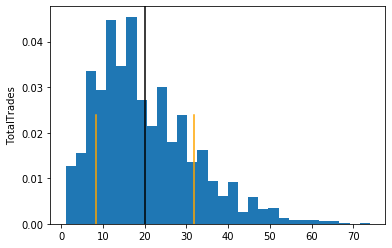

count    3046.000000
mean       20.039724
std        11.792934
min         1.000000
25%        11.000000
50%        18.000000
75%        27.000000
max        74.000000
Name: TotalTrades, dtype: float64
-----------------------------------------------------------------


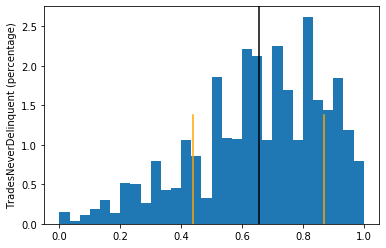

count    3046.000000
mean        0.654301
std         0.214840
min         0.000000
25%         0.520000
50%         0.680000
75%         0.820000
max         1.000000
Name: TradesNeverDelinquent (percentage), dtype: float64
-----------------------------------------------------------------


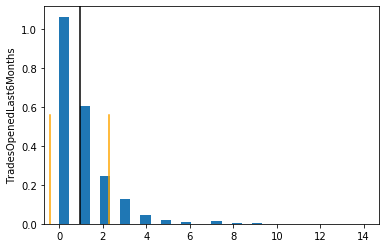

count    3046.000000
mean        0.931714
std         1.346137
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: TradesOpenedLast6Months, dtype: float64
-----------------------------------------------------------------


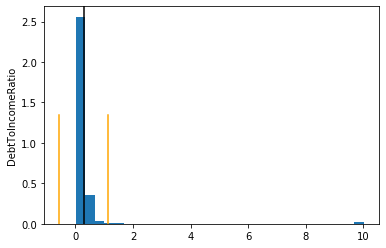

count    2837.000000
mean        0.295139
std         0.848312
min         0.010000
25%         0.110000
50%         0.180000
75%         0.280000
max        10.010000
Name: DebtToIncomeRatio, dtype: float64
-----------------------------------------------------------------


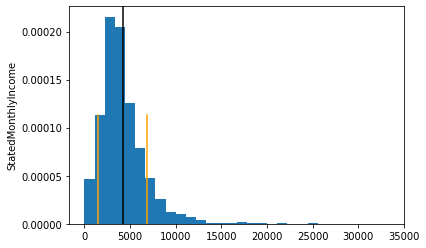

count     3046.000000
mean      4179.397680
std       2692.033672
min          0.000000
25%       2500.000000
50%       3666.666667
75%       5207.041667
max      33333.333330
Name: StatedMonthlyIncome, dtype: float64
-----------------------------------------------------------------


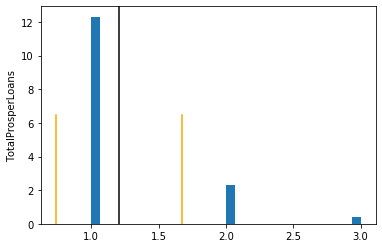

count    552.000000
mean       1.206522
std        0.467562
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: TotalProsperLoans, dtype: float64
ordinal values [nan  2.  3.  1.]
-----------------------------------------------------------------


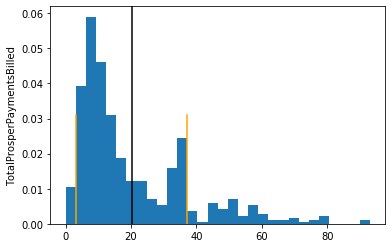

count    552.000000
mean      20.184783
std       16.888293
min        0.000000
25%        9.000000
50%       13.000000
75%       31.000000
max       93.000000
Name: TotalProsperPaymentsBilled, dtype: float64
-----------------------------------------------------------------


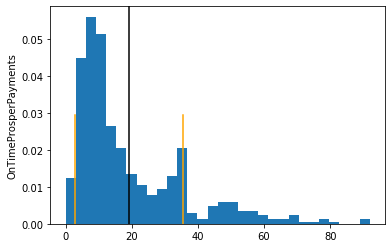

count    552.000000
mean      19.251812
std       16.367157
min        0.000000
25%        9.000000
50%       12.000000
75%       28.000000
max       92.000000
Name: OnTimeProsperPayments, dtype: float64
-----------------------------------------------------------------


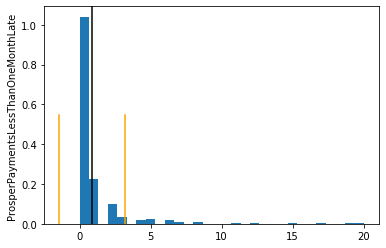

count    552.000000
mean       0.880435
std        2.306823
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       20.000000
Name: ProsperPaymentsLessThanOneMonthLate, dtype: float64
-----------------------------------------------------------------


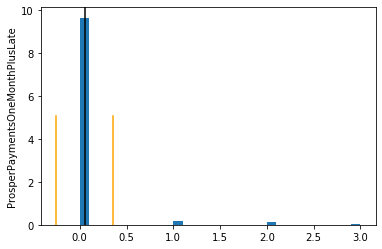

count    552.000000
mean       0.052536
std        0.305653
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: ProsperPaymentsOneMonthPlusLate, dtype: float64
ordinal values [nan  0.  2.  1.  3.]
-----------------------------------------------------------------


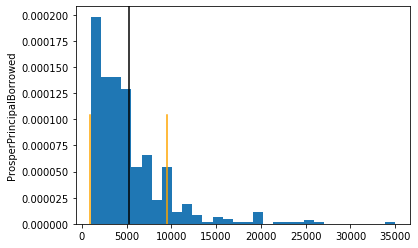

count      552.000000
mean      5229.916975
std       4304.261872
min       1000.000000
25%       2500.000000
50%       4000.000000
75%       6535.000000
max      35000.000000
Name: ProsperPrincipalBorrowed, dtype: float64
-----------------------------------------------------------------


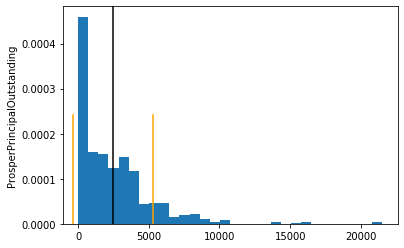

count      552.000000
mean      2454.774638
std       2820.095195
min          0.000000
25%        155.645000
50%       1777.285000
75%       3574.705000
max      21516.520000
Name: ProsperPrincipalOutstanding, dtype: float64
-----------------------------------------------------------------


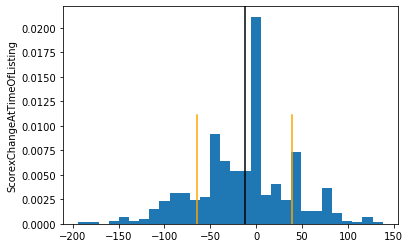

count    552.000000
mean     -12.505435
std       51.550479
min     -194.000000
25%      -40.000000
50%       -2.000000
75%       16.250000
max      138.000000
Name: ScorexChangeAtTimeOfListing, dtype: float64
-----------------------------------------------------------------


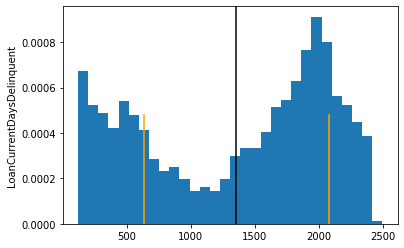

count    3046.000000
mean     1357.048260
std       723.866677
min       121.000000
25%       604.000000
50%      1587.500000
75%      1983.000000
max      2497.000000
Name: LoanCurrentDaysDelinquent, dtype: float64
-----------------------------------------------------------------


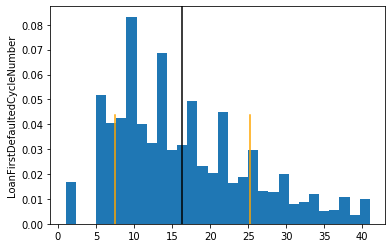

count    3046.000000
mean       16.319764
std         8.864026
min         1.000000
25%         9.000000
50%        14.000000
75%        22.000000
max        41.000000
Name: LoanFirstDefaultedCycleNumber, dtype: float64
-----------------------------------------------------------------


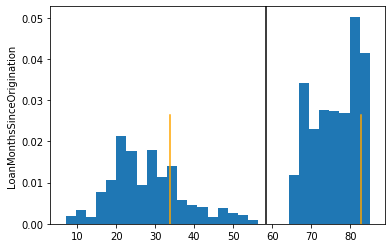

count    3046.000000
mean       58.279711
std        24.489518
min         7.000000
25%        31.000000
50%        70.000000
75%        79.000000
max        85.000000
Name: LoanMonthsSinceOrigination, dtype: float64
-----------------------------------------------------------------


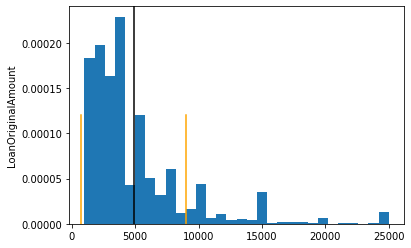

count     3046.000000
mean      4875.443204
std       4139.300179
min       1000.000000
25%       2500.000000
50%       4000.000000
75%       5768.750000
max      25000.000000
Name: LoanOriginalAmount, dtype: float64
-----------------------------------------------------------------


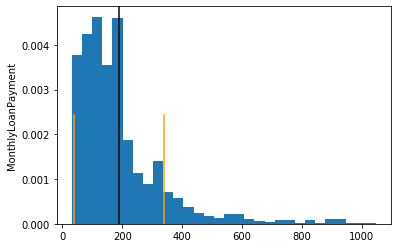

count    3046.000000
mean      188.297587
std       150.230750
min        31.110000
25%        90.470000
50%       147.640000
75%       222.750000
max      1047.640000
Name: MonthlyLoanPayment, dtype: float64
-----------------------------------------------------------------


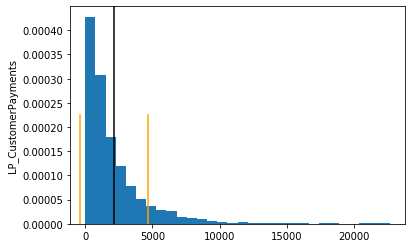

count     3046.000000
mean      2133.239498
std       2553.853138
min         -2.349900
25%        562.350000
50%       1289.935000
75%       2736.400000
max      22681.190000
Name: LP_CustomerPayments, dtype: float64
-----------------------------------------------------------------


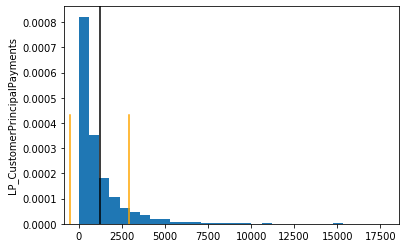

count     3046.000000
mean      1199.839255
std       1706.735855
min          0.000000
25%        232.532500
50%        622.405000
75%       1469.487500
max      17678.590000
Name: LP_CustomerPrincipalPayments, dtype: float64
-----------------------------------------------------------------


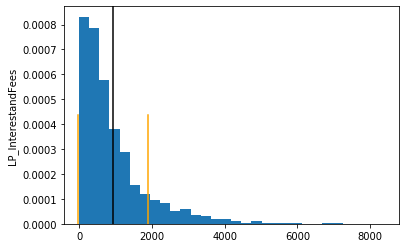

count    3046.000000
mean      933.400243
std       973.173241
min        -2.349900
25%       295.545000
50%       624.735000
75%      1203.045000
max      8358.490000
Name: LP_InterestandFees, dtype: float64
-----------------------------------------------------------------


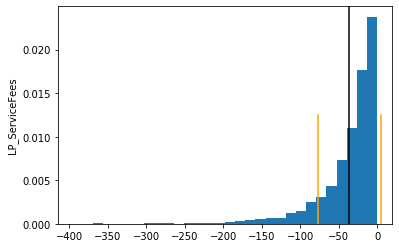

count    3046.000000
mean      -36.362531
std        41.056850
min      -395.650000
25%       -47.090000
50%       -22.765000
75%       -10.552500
max         0.000000
Name: LP_ServiceFees, dtype: float64
-----------------------------------------------------------------


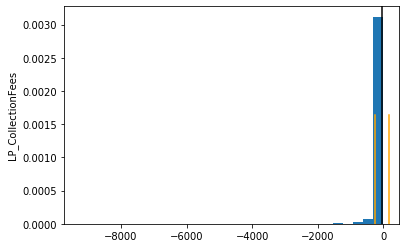

count    3046.000000
mean      -48.064566
std       224.248900
min     -9274.750000
25%       -23.070000
50%         0.000000
75%         0.000000
max         0.000000
Name: LP_CollectionFees, dtype: float64
-----------------------------------------------------------------


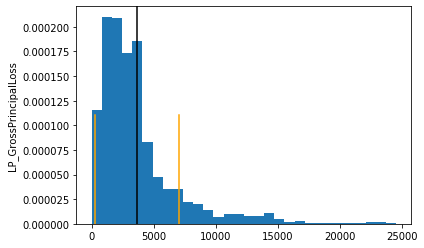

count     3046.000000
mean      3671.552269
std       3385.360464
min          1.580000
25%       1546.112500
50%       2795.680000
75%       4380.010000
max      24548.250000
Name: LP_GrossPrincipalLoss, dtype: float64
-----------------------------------------------------------------


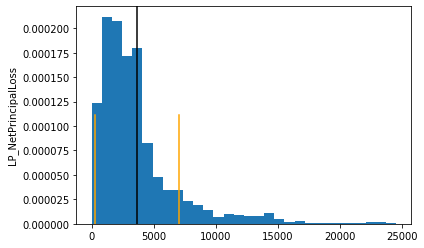

count     3046.000000
mean      3633.673844
std       3378.570006
min          0.000000
25%       1504.722500
50%       2738.880000
75%       4305.415000
max      24548.250000
Name: LP_NetPrincipalLoss, dtype: float64
-----------------------------------------------------------------


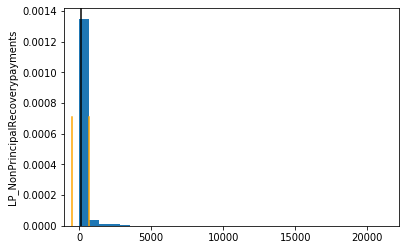

count     3046.000000
mean       122.640217
std        592.154916
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      21117.900000
Name: LP_NonPrincipalRecoverypayments, dtype: float64
-----------------------------------------------------------------


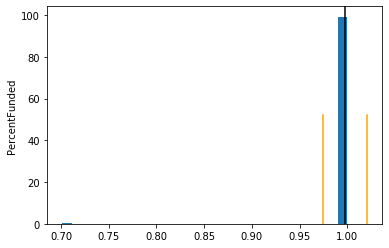

count    3046.000000
mean        0.997769
std         0.022633
min         0.701300
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: PercentFunded, dtype: float64
-----------------------------------------------------------------


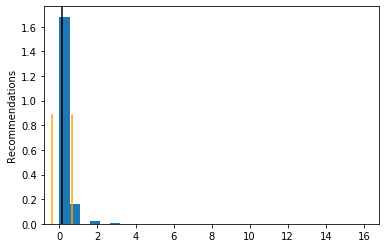

count    3046.000000
mean        0.133290
std         0.515725
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        16.000000
Name: Recommendations, dtype: float64
-----------------------------------------------------------------


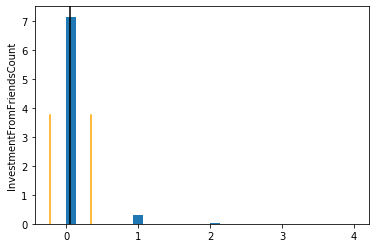

count    3046.000000
mean        0.056139
std         0.282727
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: InvestmentFromFriendsCount, dtype: float64
ordinal values [0 2 1 4 3]
-----------------------------------------------------------------


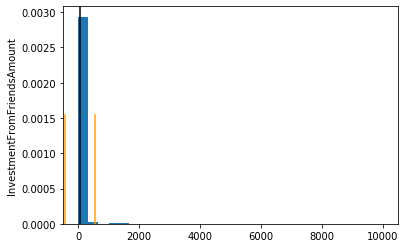

count     3046.000000
mean        54.605972
std        498.911957
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10000.000000
Name: InvestmentFromFriendsAmount, dtype: float64
-----------------------------------------------------------------


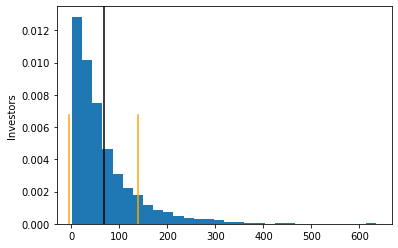

count    3046.000000
mean       67.149376
std        71.924813
min         1.000000
25%        20.000000
50%        45.000000
75%        87.000000
max       635.000000
Name: Investors, dtype: float64
-----------------------------------------------------------------


In [414]:
print ('Continuous variables frequencies')
list_ordinal_feat=[]
list_cont_feat=[]
for dtype in mydata_summary.index:
    if mydata_summary[dtype] == 'int64' or mydata_summary[dtype]=='float64':
        plt.hist(mydata[dtype], density= True, bins=30)
        plt.axvline(x=mydata[dtype].describe()['mean'], ymin=0, ymax=1, color='black')
        plt.axvline(x=(mydata[dtype].describe()['mean']-mydata[dtype].describe()['std']), ymin=0, ymax=0.5, color='orange')
        plt.axvline(x=(mydata[dtype].describe()['mean']+mydata[dtype].describe()['std']), ymin=0, ymax=0.5, color='orange')
        plt.ylabel(dtype)
    plt.show()
    if mydata_summary[dtype] == 'int64' or mydata_summary[dtype]=='float64':
        print(mydata[dtype].describe())
        if len(mydata[dtype].unique())<7:# use the number of unique values in the series to determine if the float64 or int64 series is a numeric ordinal feature, the cut is set at 7 
            print("ordinal values", mydata[dtype].unique())
            list_ordinal_feat.append(dtype)
        else:
            list_cont_feat.append(dtype)
        print('-----------------------------------------------------------------')

#listnumber is a unique key id
#most terms are 36 months, 3 year term
#borrower APR: a few spikes above mean, at about .29, .35, .375, so borrowAPR maybe important
#Employment Status Duration has a pattern - the shorter days inverse proportional with frequency counts  
#current credit line skewed right
#openCreditLines skewed right




# next step is to plot the comparison curves cross with the logit odd of repayment rate
# what about repayment amount

In [416]:
print ("The list of Ordinal Features is",list_ordinal_feat)
print()
print()
print ("The list of Continuous Features is",list_cont_feat)

The list of Ordinal Features is ['Term', 'PublicRecordsLast12Months', 'TotalProsperLoans', 'ProsperPaymentsOneMonthPlusLate', 'InvestmentFromFriendsCount']


The list of Continuous Features is ['ListingNumber', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)', 'EmploymentStatusDuration', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPrincipalBorrowed', 'Pr

### ordinal or categorical (numeric) types are:
Term, ProsperRating (numeric),  CreditScoreRangeLower, 


Categorical variables frequencies
count     1919
unique       7
top         HR
freq       560
Name: CreditGrade, dtype: object


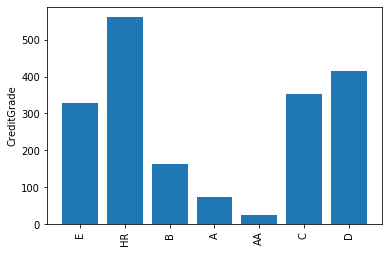

-----------------------------------
count     2842
unique      50
top         CA
freq       383
Name: BorrowerState, dtype: object


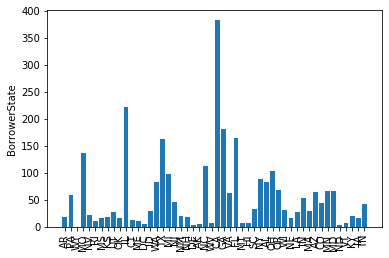

-----------------------------------
count          3046
unique            7
top       Full-time
freq           1857
Name: EmploymentStatus, dtype: object


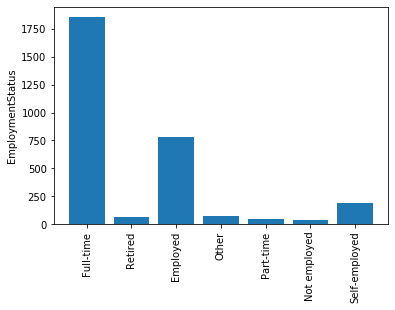

-----------------------------------
count               3046
unique                 8
top       $25,000-49,999
freq                1322
Name: IncomeRange, dtype: object


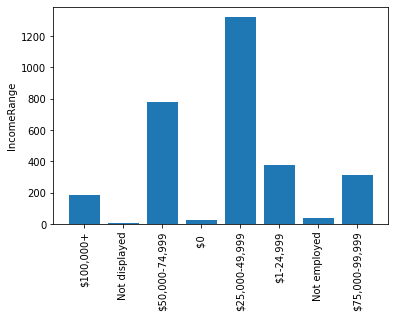

-----------------------------------
count        3046
unique         25
top       Q2 2007
freq          436
Name: LoanOriginationQuarter, dtype: object


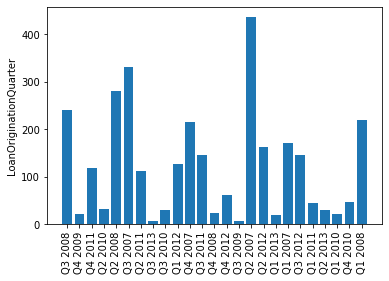

-----------------------------------


In [418]:
from scipy import stats
print ('Categorical variables frequencies')
for dtype in ['CreditGrade','BorrowerState','EmploymentStatus','IncomeRange','LoanOriginationQuarter']:
#    if mydata_summary[dtype] == 'object'and dtype not in ['','']:
        table=mydata[dtype].value_counts(sort=False)
        fig = plt.bar(table.index, table, label= dtype)
        plt.xticks(rotation=90)
        plt.ylabel(dtype)
        print(mydata[dtype].describe())
        plt.show()
        print('-----------------------------------')

In [601]:
mydata['rec_rate'] = mydata.apply(lambda x: x.LP_NonPrincipalRecoverypayments /(x.AmountDelinquent-x.LP_CollectionFees), axis=1)
# set the repayment rate to maximum of 1
mydata['rec_rate'] = mydata['rec_rate'].map(lambda x: min(x,1))
#assign classification propensity as repayment rate to five classes: VeryLow, Low, Medium, High, VeryHigh, Paid
'''mydata['rec_propen'] = mydata[mydata['rec_rate'] <= 1].apply(lambda x : 'VeryHigh', axis=1) 
mydata['rec_propen'] = mydata.apply(lambda x : 'High' if 0.6 < x.rec_rate <= 0.8 else 'Medium', axis=1) 
mydata['rec_propen'] = mydata.apply(lambda x : 'Medium' if x.rec_rate <= 0.6 else x.rec_propen, axis=1) 
mydata['rec_propen'] = mydata.apply(lambda x : 'Low' if x.rec_rate <= 0.4 else x.rec_propen, axis=1) 
mydata['rec_propen'] = mydata.apply(lambda x : 'VeryLow' if x.rec_rate <= 0.2 else x.rec_propen, axis=1) 
mydata[mydata.rec_rate>=1]['rec_propen']=mydata['rec_rate'].map(lambda x : 'Paid')
'''
mydata['rec_propen'] = mydata.apply(lambda x : int(x.rec_rate*5), axis=1) 
#mydata['rec_propen']=mydata['rec_propen'].map({0:'VeryLow',1: 'Low', 2: 'Medium',3:'High',4:'VeryHigh',5: 'Paid'})

mydata

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,rec_rate,rec_propen
0,0DEB351032566848818E832,496566,21:40.3,NaN,36,Chargedoff,2013/9/15 0:00,0.35643,0.3199,0.3099,...,1031.89,1031.89,0.00,1.0000,0,0,0.0,50,0.000000,0
1,10F83416199324455232962,292860,04:51.6,HR,36,Chargedoff,2009/2/22 0:00,0.29743,0.2745,0.2645,...,2293.09,2293.09,0.00,1.0000,0,0,0.0,67,0.000000,0
2,349134175738976507325F1,308345,33:07.7,B,36,Chargedoff,2008/11/23 0:00,0.15882,0.1445,0.1345,...,2387.70,2387.70,0.00,1.0000,0,0,0.0,85,0.000000,0
3,30423527854712576FEBDB0,532077,39:41.2,NaN,36,Chargedoff,2012/5/18 0:00,0.35132,0.3149,0.3049,...,5793.94,5793.94,0.00,1.0000,0,0,0.0,2,0.000000,0
4,08E134244479824305E38AA,361026,32:23.2,B,36,Chargedoff,2010/12/10 0:00,0.15377,0.1395,0.1295,...,1608.01,1608.05,85.00,1.0000,0,0,0.0,92,0.758929,3
5,00F73576880451894AC2493,758046,01:29.3,NaN,60,Chargedoff,2013/10/23 0:00,0.32393,0.2969,0.2869,...,3877.86,3877.86,0.00,1.0000,0,0,0.0,58,0.000000,0
6,01243393178178057DBC812,162461,49:12.6,E,36,Chargedoff,2009/1/11 0:00,0.28545,0.2700,0.2600,...,2184.36,2184.36,0.00,1.0000,0,0,0.0,27,0.000000,0
7,010E3535902893498204A4A,551688,20:22.2,NaN,36,Chargedoff,2013/8/24 0:00,0.34577,0.3058,0.2958,...,2939.00,2939.00,0.00,1.0000,0,0,0.0,2,0.000000,0
8,010A3421255456297C4F689,340424,18:20.0,D,36,Chargedoff,2009/3/7 0:00,0.23250,0.2100,0.2000,...,944.02,944.02,0.00,1.0000,1,0,0.0,37,0.000000,0
9,089C348555489823736377D,460749,37:25.0,NaN,36,Chargedoff,2013/1/11 0:00,0.24807,0.2100,0.2000,...,383.08,383.08,0.00,1.0000,0,0,0.0,31,0.000000,0


Which features are after=the-fact features (after the repayment rate) or leakage?

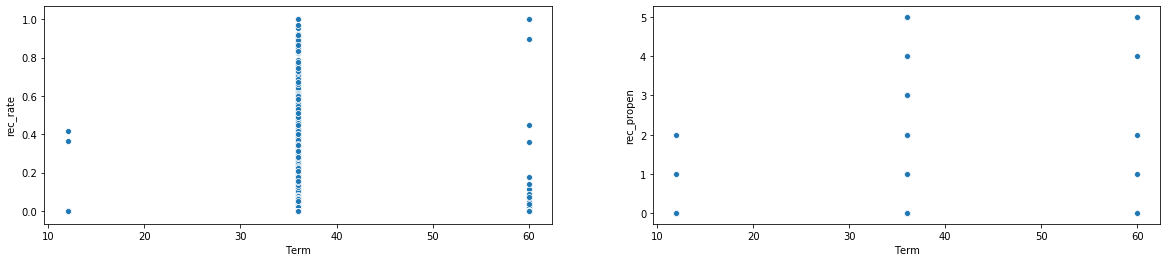

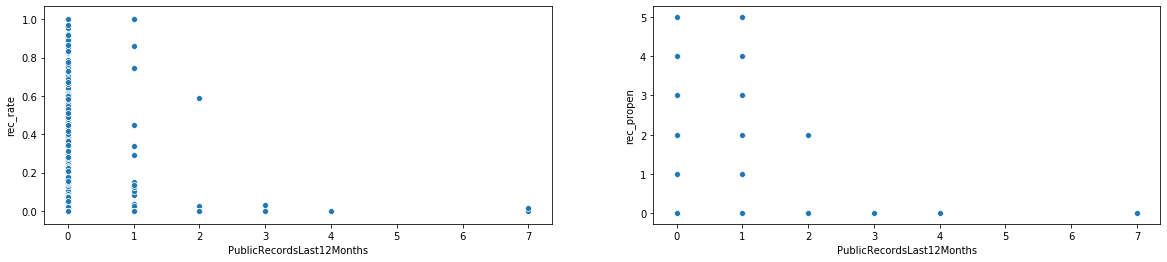

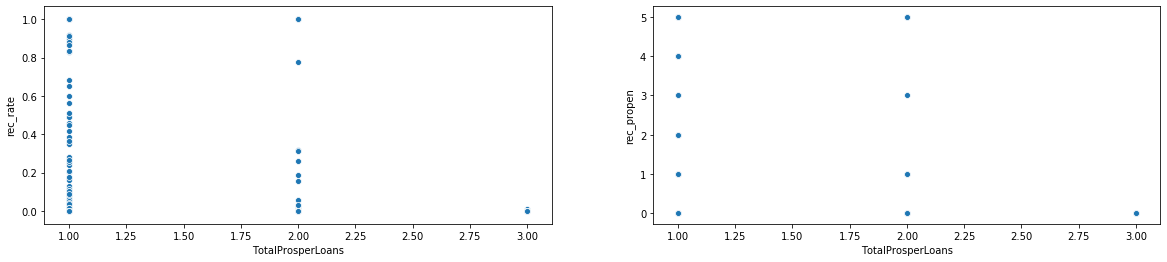

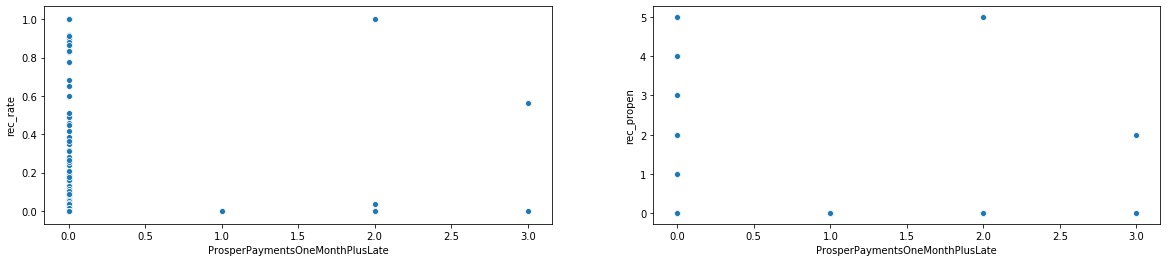

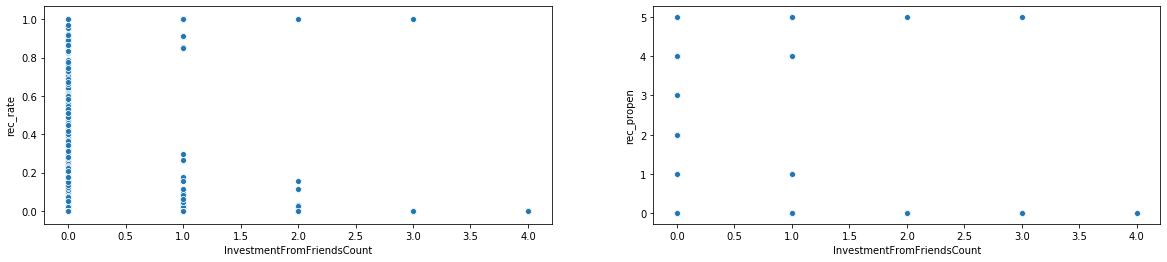

In [604]:
#Correlational plot of continous feat against the recollection/ repayment rate
for feat in list_ordinal_feat:
    fig = plt.figure(figsize = (20,4))
    ax1 = fig.add_subplot(121)
    ax1 = sns.scatterplot(mydata[feat],mydata['rec_rate'])
    ax2 = fig.add_subplot(122)
    ax2 = sns.scatterplot(mydata[feat],mydata['rec_propen'])
    plt.show()

In [ ]:
'''# use side-by-side histogram plot of continuous variable to explore possible significant differences
for catg in df_summary.index:
    if df_summary[catg] == 'int64':
        df_select=pd.DataFrame(df['deposit'])
        df_select[catg]=df[catg]
        ax_yes=plt.subplot(211)
        df_select_yes = df_select[df_select.deposit== 'yes']
        ax_yes.hist(df_select_yes[catg], bins=100, color = 'blue')
        ax_no=plt.subplot(212)
        df_select_no = df_select[df_select.deposit== 'no']
        ax_no.hist(df_select_no[catg], bins=100, color='green')
        ax_yes.set_title('Histogram with %s' % catg, size = 20)
        ax_no.set_xlabel(catg, size = 16)
        ax_no.set_ylabel('Frequency', size= 16)
        ax_yes.set_ylabel('Frequency', size= 16)
        plt.show()        
#    df_select[df_select.deposit== 'yes'].plot(kind='hist', bins=180)
#    df_select[df_select.deposit== 'no'].plot(kind='hist',bins=180)'''

In [289]:
# use superimposed distribution plot of continuous variable to explore possible significant differencesfor catg in data.index:
# run t-test or z-test compare between yes and no      
#!!! needs a lot of revision

#choose a 
import statsmodels.stats.weightstats as stmodel
target =''#choose a boolean type feature, use t-test
for dtype in mydata_summary.index:
    if mydata_summary[dtype] == 'int64'or mydata_summary[dtype] =='float64':
        mydata_select=pd.DataFrame(mydata[target])
        mydata_select[dtype]=mydata[dtype]
        plt.figure(figsize=(12,6))
        mydata_select_yes = mydata_select[mydata_select[target]== 'yes']
        sns.distplot(mydata_select_yes[catg], hist=False, norm_hist=True, color='blue', label='sign up deposit')
        mydata_select_no = mydata_select[mydata_select[target]== 'no']
        sns.distplot(df_select_no[catg], hist=False, norm_hist=True, color ='red', label='no sign up')
        plt.title("comparison of "+catg, size=20)
        plt.show()
#        tstat, p_value=stats.ttest_ind(df_select_yes[catg],df_select_no[catg])
        tstat, p_value=stmodel.ztest(df_select_yes[catg],df_select_no[catg])
        print("t-statistic is", tstat, "and the p-value is",p_value)
        if p_value < 0.05:
            print("Significant predictor")

KeyError: 'deposit'

### 4.变量预处理
> 还款率定义：还款率=催收回款/(所欠本金+利息+催收成本)

In [275]:
mydata['rec_rate'] = mydata.apply(lambda x: x.LP_NonPrincipalRecoverypayments /(x.AmountDelinquent-x.LP_CollectionFees), axis=1)
# 限定还款率最大为1
mydata['rec_rate'] = mydata['rec_rate'].map(lambda x: min(x,1))


> 数据划分:4/6开

In [397]:
trainData, testData = train_test_split(mydata,test_size=0.4)

> 分类变量&连续变量划分

In [399]:
categoricalFeatures = ['CreditGrade','Term','BorrowerState','Occupation','EmploymentStatus','IsBorrowerHomeowner','CurrentlyInGroup','IncomeVerifiable']

numFeatures = ['BorrowerAPR','BorrowerRate','LenderYield','ProsperRating (numeric)','ProsperScore','ListingCategory (numeric)','EmploymentStatusDuration','CurrentCreditLines',
                'OpenCreditLines','TotalCreditLinespast7years','CreditScoreRangeLower','OpenRevolvingAccounts','OpenRevolvingMonthlyPayment','InquiriesLast6Months','TotalInquiries',
               'CurrentDelinquencies','DelinquenciesLast7Years','PublicRecordsLast10Years','PublicRecordsLast12Months','BankcardUtilization','TradesNeverDelinquent (percentage)',
               'TradesOpenedLast6Months','DebtToIncomeRatio','LoanFirstDefaultedCycleNumber','LoanMonthsSinceOrigination','PercentFunded','Recommendations','InvestmentFromFriendsCount',
               'Investors']

In [17]:
mydata[numFeatures].describe()

,BorrowerAPR,BorrowerRate,LenderYield,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,...,BankcardUtilization,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,PercentFunded,Recommendations,InvestmentFromFriendsCount,Investors
count,3046.000000,3046.000000,3046.000000,1126.000000,1126.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,...,3046.000000,3046.000000,3046.000000,2837.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000
mean,0.278995,0.256069,0.244253,2.480462,4.760213,2.347997,79.839133,6.940250,6.135916,26.387065,...,0.512850,0.654301,0.931714,0.295139,16.319764,58.279711,0.997769,0.133290,0.056139,67.149376
std,0.074141,0.067817,0.068459,1.319620,2.097460,3.444284,85.774270,4.786034,4.322763,14.431227,...,0.433415,0.214840,1.346137,0.848312,8.864026,24.489518,0.022633,0.515725,0.282727,71.924813
min,0.029980,0.010000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.010000,1.000000,7.000000,0.701300,0.000000,0.000000,1.000000
25%,0.223635,0.204900,0.190000,1.000000,3.000000,0.000000,19.000000,3.000000,3.000000,16.000000,...,0.030000,0.520000,0.000000,0.110000,9.000000,31.000000,1.000000,0.000000,0.000000,20.000000
50%,0.291035,0.262750,0.250000,2.000000,5.000000,1.000000,50.000000,6.000000,5.000000,24.000000,...,0.530000,0.680000,1.000000,0.180000,14.000000,70.000000,1.000000,0.000000,0.000000,45.000000
75%,0.351320,0.315225,0.305225,3.000000,6.000000,3.000000,111.000000,9.000000,8.000000,35.000000,...,0.900000,0.820000,1.000000,0.280000,22.000000,79.000000,1.000000,0.000000,0.000000,87.000000
max,0.423950,0.360000,0.340000,7.000000,10.000000,20.000000,532.000000,33.000000,31.000000,118.000000,...,2.680000,1.000000,14.000000,10.010000,41.000000,85.000000,1.000000,16.000000,4.000000,635.000000


> 对分类变量进行编码：编码 = 类别对应的平均还款率

In [400]:
encodedFeatures = []
encodedDict = {}
for var in categoricalFeatures:
    trainData[var] = trainData[var].map(MakeupMissingCategorical)
    avgTarget = trainData.groupby([var])['rec_rate'].mean()
    avgTarget = avgTarget.to_dict()
    newVar = var + '_encoded'
    newVarSeries = trainData[var].map(avgTarget)
    trainData[newVar] = newVarSeries
    encodedFeatures.append(newVar)
    encodedDict[var] = avgTarget


C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [401]:
trainData[encodedFeatures].head()

,CreditGrade_encoded,Term_encoded,BorrowerState_encoded,Occupation_encoded,EmploymentStatus_encoded,IsBorrowerHomeowner_encoded,CurrentlyInGroup_encoded,IncomeVerifiable_encoded
77,0.124832,0.07403,0.068515,0.051133,0.083803,0.070362,0.067302,0.072174
2259,0.059158,0.07403,0.001435,0.065924,0.058517,0.070362,0.067302,0.072174
528,0.059158,0.07403,0.096950,0.104725,0.058517,0.070362,0.081362,0.072174
172,0.060399,0.07403,0.024604,0.024082,0.083803,0.072242,0.081362,0.072174
2076,0.059158,0.07403,0.088577,0.027673,0.083803,0.070362,0.067302,0.072174


> 对连续变量缺失值进行填充

In [402]:
trainData['ProsperRating (numeric)'] = trainData['ProsperRating (numeric)'].map(lambda x: MakeupMissingNumerical(x,0))
trainData['ProsperScore'] = trainData['ProsperScore'].map(lambda x: MakeupMissingNumerical(x,0))

avgDebtToIncomeRatio = np.mean(trainData['DebtToIncomeRatio'])
trainData['DebtToIncomeRatio'] = trainData['DebtToIncomeRatio'].map(lambda x: MakeupMissingNumerical(x,avgDebtToIncomeRatio))

C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

### 5.模型开发
1.第三步：调参
>对基于CART的随机森林的调参，主要有：
1，树的个数
2，树的最大深度
3，内部节点最少样本数与叶节点最少样本数
4，特征个数

>此外，调参过程中选择的误差函数是均值误差，5倍折叠

> 变量选择：将编码后的字符串变量选入训练集
> 根据网格搜索法搜索最佳分类器数量：
1. 范围{from:10, to:80, step:5}
2. 最小样本：50， 叶结点最小样本：10， 最大深度：8， 最大特征：sqrt(k)， 评价方法：mse

In [403]:
numFeatures2 = numFeatures + encodedFeatures
X, y= trainData[numFeatures2],trainData['rec_rate']

param_test1 = {'n_estimators':range(10,80,5)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=50,min_samples_leaf=10,max_depth=8,max_features='sqrt' ,random_state=10),
                       param_grid = param_test1, scoring='neg_mean_squared_error',cv=5)
gsearch1.fit(X,y)
gsearch1.best_params_, gsearch1.best_score_
best_n_estimators = gsearch1.best_params_['n_estimators']

In [404]:
gsearch1.best_params_

{'n_estimators': 55}

> 运用网格搜索法，搜索其他最佳参数
2. 最大深度&最小样本分割
3. 最小样本分割&最小叶结点
4. 最大特征

In [405]:
param_test2 = {'max_depth':range(3,21), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=best_n_estimators, min_samples_leaf=10,max_features='sqrt' ,random_state=10,oob_score=True),
                       param_grid = param_test2, scoring='neg_mean_squared_error',cv=5)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_
best_max_depth = gsearch2.best_params_['max_depth']
best_min_sample_split = gsearch2.best_params_['min_samples_split']

param_test3 = {'min_samples_split':range(50,201,10), 'min_samples_leaf':range(1,20,2)}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=best_n_estimators, max_depth = best_max_depth,max_features='sqrt',random_state=10,oob_score=True),
                       param_grid = param_test3, scoring='neg_mean_squared_error',cv=5)
gsearch3.fit(X,y)
gsearch3.best_params_, gsearch3.best_score_
best_min_samples_leaf = gsearch3.best_params_['min_samples_leaf']
best_min_samples_split = gsearch3.best_params_['min_samples_split']


In [406]:
numOfFeatures = len(numFeatures2)
mostSelectedFeatures = numOfFeatures/2
param_test4 = {'max_features':range(3,numOfFeatures+1)}
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,min_samples_leaf=best_min_samples_leaf,
                                                          min_samples_split=best_min_samples_split,random_state=10,oob_score=True),
                       param_grid = param_test4, scoring='neg_mean_squared_error',cv=5)
gsearch4.fit(X,y)
gsearch4.best_params_, gsearch4.best_score_
best_max_features = gsearch4.best_params_['max_features']

In [407]:
print(gsearch2.best_params_)
print(gsearch1.best_params_)
print(gsearch3.best_params_)
print(gsearch4.best_params_)

{'max_depth': 10, 'min_samples_split': 10}
{'n_estimators': 55}
{'min_samples_leaf': 1, 'min_samples_split': 50}
{'max_features': 7}


In [408]:
print('最佳深度: %d' % best_max_depth)
print('最佳深度: %d' % best_n_estimators)
print('最小叶结点样本：%d' % best_min_samples_leaf)
print('最小样本分割： %d' % best_min_samples_split)
print('最大特征: %.2f' % best_max_features)

最佳深度: 10
最佳深度: 55
最小叶结点样本：1
最小样本分割： 50
最大特征: 7.00


> 根据之前训练得到的最佳参数拟合模型

In [409]:
cls = RandomForestRegressor(n_estimators=best_n_estimators,
                            max_depth=best_max_depth,
                            min_samples_leaf=best_min_samples_leaf,
                            min_samples_split=best_min_samples_split,
                            max_features=best_max_features,
                            random_state=10,
                            oob_score=True)
cls.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=55,
                      n_jobs=None, oob_score=True, random_state=10, verbose=0,
                      warm_start=False)

> 预测结果输出，并比较预测结果与真实还款情况
* 输出预测结果高于真实情况的比率
* 输出预测与真实结果的mae

In [410]:
trainData['pred'] = cls.predict(trainData[numFeatures2])
trainData['less_rr'] = trainData.apply(lambda x: int(x.pred > x.rec_rate), axis=1)
print(np.mean(trainData['less_rr']))
err = trainData.apply(lambda x: np.abs(x.pred - x.rec_rate), axis=1) #accuracy score
print(np.mean(err))

C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.8708264915161467
0.09879216039683814


C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 6.模型验证
* 输出预测结果高于真实情况的比率
* 输出预测与真实结果的mae

In [411]:
# 对测试数据中的字符串变量运用同样的方法进行编码
for var in categoricalFeatures:
    testData[var] = testData[var].map(MakeupMissingCategorical)
    newVar = var + '_encoded'
    testData[newVar] = testData[var].map(encodedDict[var])
    avgnewVar = np.mean(trainData[newVar])
    testData[newVar] = testData[newVar].map(lambda x: MakeupMissingNumerical(x, avgnewVar))

# 对测试数据中的连续变量运用同样的方法进行缺值填补
testData['ProsperRating (numeric)'] = testData['ProsperRating (numeric)'].map(lambda x: MakeupMissingNumerical(x,0))
testData['ProsperScore'] = testData['ProsperScore'].map(lambda x: MakeupMissingNumerical(x,0))
testData['DebtToIncomeRatio'] = testData['DebtToIncomeRatio'].map(lambda x: MakeupMissingNumerical(x,avgDebtToIncomeRatio))

testData['pred'] = cls.predict(testData[numFeatures2])
testData['less_rr'] = testData.apply(lambda x: int(x.pred > x.rec_rate), axis=1)
print(np.mean(testData['less_rr']))
err = testData.apply(lambda x: np.abs(x.pred - x.rec_rate), axis=1)
print(np.mean(err))

C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

0.8736669401148482
0.11728702492909189


C:\Users\pohch\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
